<a href="https://colab.research.google.com/github/EliorDS/TellMeWhy/blob/main/chocolat_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()  # Select the kaggle.json file

In [3]:
import os
import zipfile

# Make a directory for kaggle
os.makedirs("/root/.kaggle", exist_ok=True)

# Move the kaggle.json file to this directory
!mv kaggle.json /root/.kaggle/

# Set permissions (required)
!chmod 600 /root/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d atharvasoundankar/chocolate-sales

Dataset URL: https://www.kaggle.com/datasets/atharvasoundankar/chocolate-sales
License(s): MIT


In [5]:
with zipfile.ZipFile("chocolate-sales.zip", 'r') as zip_ref:
    zip_ref.extractall("chocolate-sales")

In [6]:
# Import libraries and set up the notebook
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')  # Use Agg backend
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer

# For permutation importance
from sklearn.inspection import permutation_importance

# Display version info (if needed for debugging)
print("Python version:", pd.__version__)
print("Pandas version:", pd.__version__)


Python version: 2.2.2
Pandas version: 2.2.2


In [19]:
# Load the dataset
file_path = '/content/chocolate-sales/Chocolate Sales.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe to inspect it (commented out since outputs are not included in this JSON)
print(df.head())
print("\n\n")
# Convert the 'Date' column to datetime. If an error is encountered, ensure the format is proper.
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Check for missing dates after conversion
print('Missing Date values:', df['Date'].isnull().sum())
print("\n\n")
# The regex [\$,€£] matches $, €, or £. You can add more symbols if needed.
df['amount_clean'] = df['Amount'].str.replace(r'[\$,€£]', '', regex=True)
df['amount_clean'] = df['amount_clean'].str.replace(',', '', regex=False)
df['amount_clean'] = df['amount_clean'].astype(float)
print('Missing amount values:', df['amount_clean'].isnull().sum())
print("\n\n")
df['Boxes Shipped'] = pd.to_numeric(df['Boxes Shipped'], errors='coerce')
print(df.head())
print("\n\n")


     Sales Person    Country              Product       Date    Amount  \
0  Jehu Rudeforth         UK      Mint Chip Choco  04-Jan-22   $5,320    
1     Van Tuxwell      India        85% Dark Bars  01-Aug-22   $7,896    
2    Gigi Bohling      India  Peanut Butter Cubes  07-Jul-22   $4,501    
3    Jan Morforth  Australia  Peanut Butter Cubes  27-Apr-22  $12,726    
4  Jehu Rudeforth         UK  Peanut Butter Cubes  24-Feb-22  $13,685    

   Boxes Shipped  
0            180  
1             94  
2             91  
3            342  
4            184  



Missing Date values: 0



Missing amount values: 0



     Sales Person    Country              Product       Date    Amount  \
0  Jehu Rudeforth         UK      Mint Chip Choco 2022-01-04   $5,320    
1     Van Tuxwell      India        85% Dark Bars 2022-08-01   $7,896    
2    Gigi Bohling      India  Peanut Butter Cubes 2022-07-07   $4,501    
3    Jan Morforth  Australia  Peanut Butter Cubes 2022-04-27  $12,726    
4  Jehu Rudefo

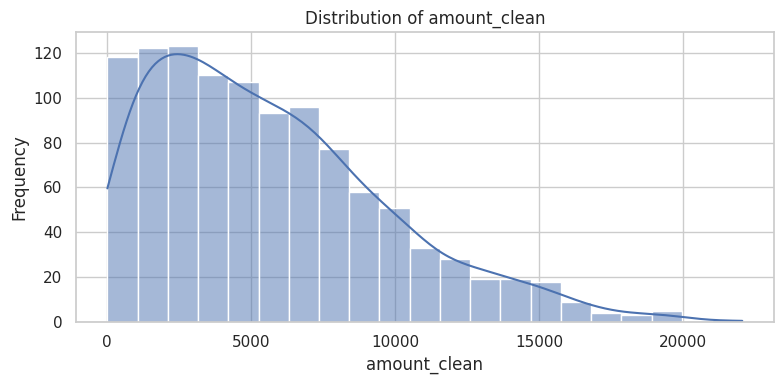

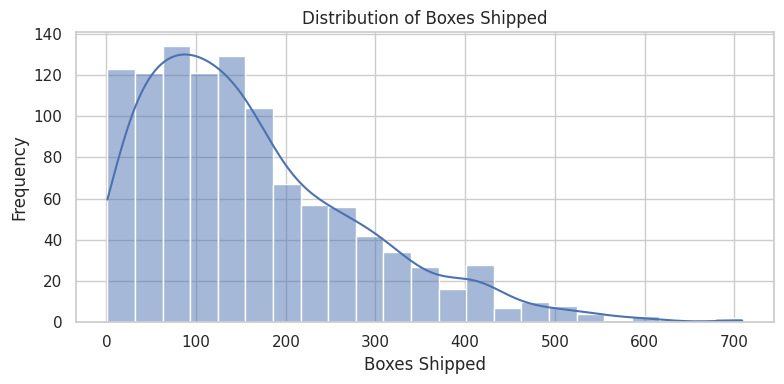

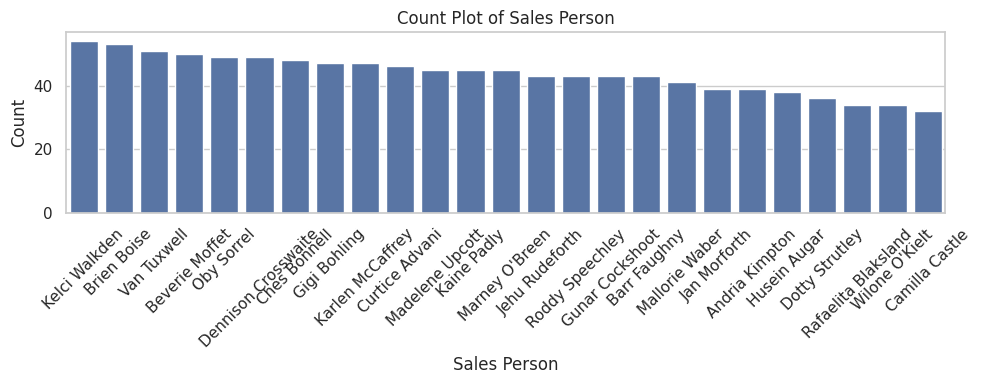

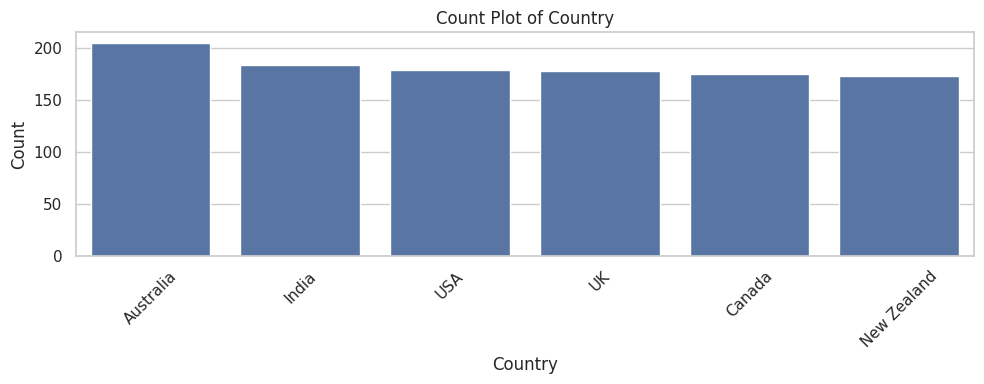

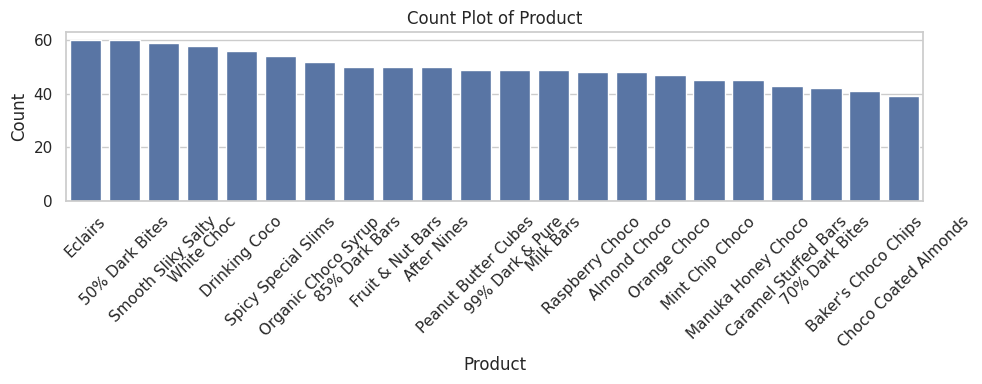

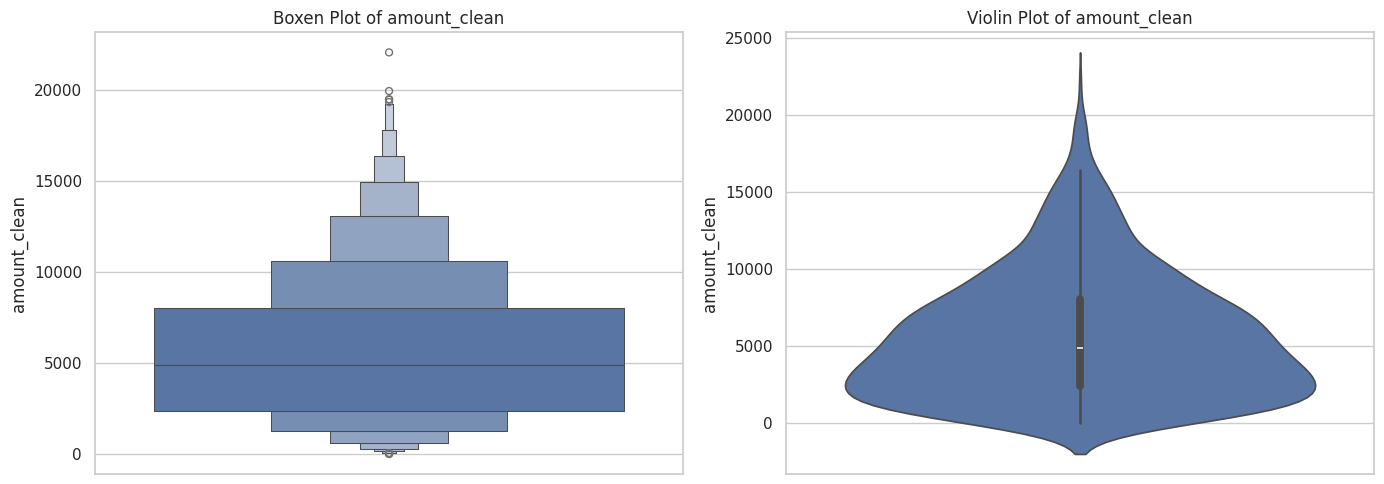

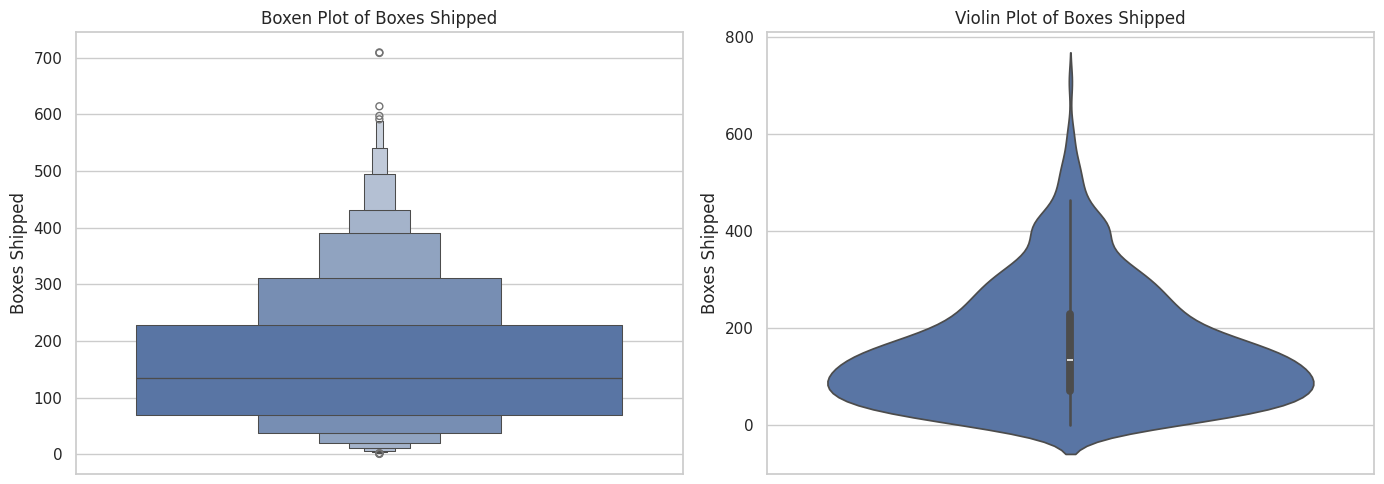

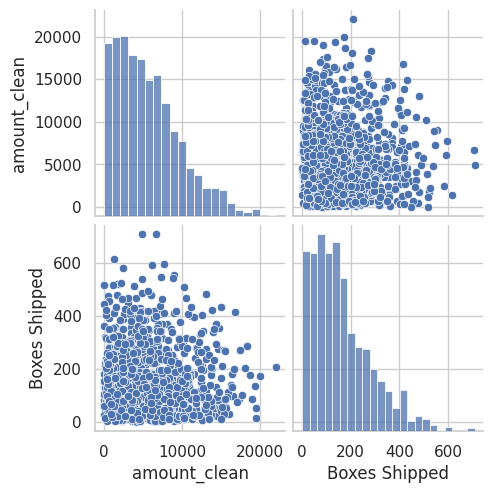

In [20]:
# Determine numeric and categorical columns
numeric_cols = ['amount_clean', 'Boxes Shipped']
categorical_cols = ['Sales Person', 'Country', 'Product']

# Plot histograms for numeric variables
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Plot count plots for categorical variables
for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Count Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Boxen and violin plots for numeric columns to inspect for outliers
for col in numeric_cols:
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    sns.boxenplot(y=df[col], ax=ax[0])
    ax[0].set_title(f'Boxen Plot of {col}')
    sns.violinplot(y=df[col], ax=ax[1])
    ax[1].set_title(f'Violin Plot of {col}')
    plt.tight_layout()
    plt.show()

# Pairplot to inspect relationships. Since there are only 2 numeric columns, this is a simple visualization.
sns.pairplot(df[numeric_cols])
plt.show()


R² Score: -0.147
Root Mean Squared Error: 140.742


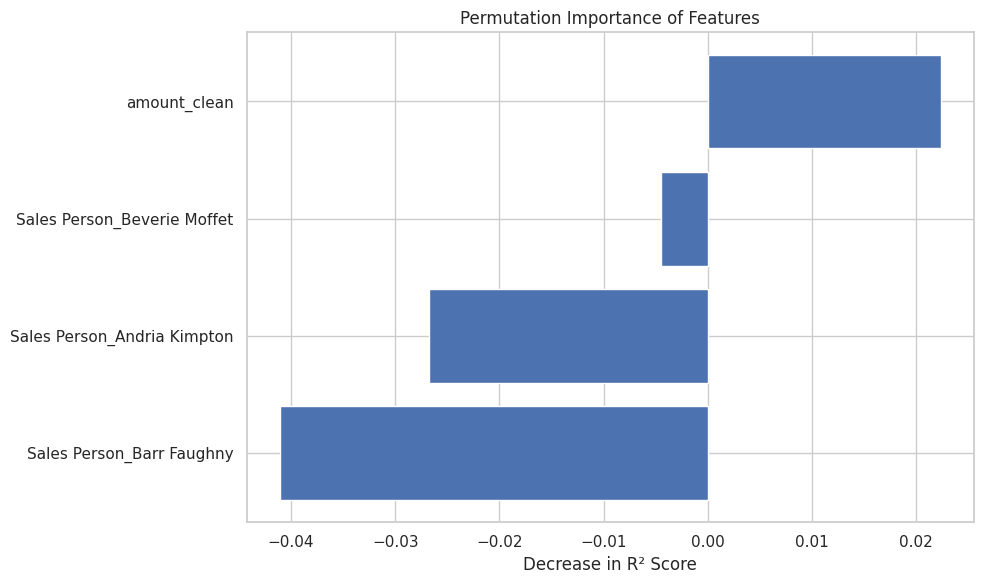

In [24]:
# Prepare data for prediction
# The target is 'Boxes Shipped'. For predictors, we use 'Sales Person', 'Country', 'Product' and 'Amount'.

features = ['Sales Person', 'Country', 'Product', 'amount_clean']
target = 'Boxes Shipped'

# Drop rows where the target or features are missing
model_df = df[features + [target]].dropna()

# Split data into training and testing sets
X = model_df[features]
y = model_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing for categorical and numeric columns
categorical_features = ['Sales Person', 'Country', 'Product']
numeric_features = ['amount_clean']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create a pipeline with preprocessor and a random forest regressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate predictions
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)**0.5

print(f"R² Score: {r2:.3f}")
print(f"Root Mean Squared Error: {mse:.3f}")

# Permutation importance
result = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42, scoring='r2')

# Extract feature names after preprocessing
# The OneHotEncoder produces feature names that we can get using get_feature_names_out
cat_encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = list(cat_encoder.get_feature_names_out(categorical_features))
all_feature_names = numeric_features + cat_feature_names

# Plot permutation importance
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), [all_feature_names[i] for i in sorted_idx])
plt.title('Permutation Importance of Features')
plt.xlabel('Decrease in R² Score')
plt.tight_layout()
plt.show()


In [26]:
print(list(zip(y_pred,y_test)))

[(np.float64(131.03), 60), (np.float64(134.08), 30), (np.float64(111.5), 420), (np.float64(149.45), 104), (np.float64(171.7), 356), (np.float64(222.0), 20), (np.float64(219.78), 209), (np.float64(173.86), 138), (np.float64(146.89), 205), (np.float64(133.98), 308), (np.float64(194.06), 12), (np.float64(159.55), 172), (np.float64(138.59), 175), (np.float64(240.68), 258), (np.float64(171.22), 135), (np.float64(174.69), 249), (np.float64(130.16), 84), (np.float64(180.13), 41), (np.float64(192.75), 207), (np.float64(271.01), 457), (np.float64(101.43), 102), (np.float64(192.45), 46), (np.float64(200.33), 138), (np.float64(126.24), 103), (np.float64(131.72), 42), (np.float64(243.64), 101), (np.float64(128.66), 264), (np.float64(173.01), 118), (np.float64(228.36), 6), (np.float64(127.76), 401), (np.float64(148.09), 112), (np.float64(152.27), 229), (np.float64(116.03), 277), (np.float64(119.45), 23), (np.float64(187.67), 109), (np.float64(183.58), 271), (np.float64(140.5), 56), (np.float64(172.